In [22]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image

from nltk.stem import PorterStemmer
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# Load Twitter captions data
labels = pd.read_csv("captions.txt")[["Caption", "image_id"]]
labels

,Caption,image_id
0,A child in a pink dress is climbing up a set o...,1000268201_693b08cb0e.jpg
1,A girl going into a wooden building .,1000268201_693b08cb0e.jpg
2,A little girl climbing into a wooden playhouse .,1000268201_693b08cb0e.jpg
3,A little girl climbing the stairs to her playh...,1000268201_693b08cb0e.jpg
4,A little girl in a pink dress going into a woo...,1000268201_693b08cb0e.jpg
...,...,...
40450,A man in a pink shirt climbs a rock face,997722733_0cb5439472.jpg
40451,A man is rock climbing high in the air .,997722733_0cb5439472.jpg
40452,A person in a red shirt climbing up a rock fac...,997722733_0cb5439472.jpg
40453,A rock climber in a red shirt .,997722733_0cb5439472.jpg


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Caption   40455 non-null  object
 1   image_id  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [28]:
# Feature Extraction
# vgg = VGG16()
# vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)
# vgg.summary()
resnet = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
resnet = Model(inputs=resnet.input, outputs=resnet.layers[-2].output)
resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [30]:
# Extract image features
features = {}
BASE_DIR = "./Images/"
images = os.listdir(BASE_DIR)

for img in images:
    try:
        img_path = os.path.join(BASE_DIR, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)

        feature = resnet.predict(image, verbose=0)

        image_idx = str(img).split(".")[0]
        features[image_idx] = feature
    except Exception as e:
        print(f"Error processing {img}: {e}")


# Save features
with open("image_features.pkl", "wb") as f:
    pickle.dump(features, f)

In [4]:
# Preprocess Twitter captions
class Preprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words("english"))

    def remove_username(self, tweet):
        return re.sub(r"@(\w+)", "", tweet)
    
    def remove_punctuations(self, tweet):
        puncs = [".", ",", "!", "?", ":", ";", "-", "_", "(", ")", "[", "]", "{", "}", "<", ">", "/", "\\", "|", "@", "$", "%", "^", "&", "*", "+", "=", "~", "`", "RT"]
        for punc in puncs:
            tweet = tweet.replace(punc, "")
        return tweet

    def remove_stopwords(self, tweet):
        stop_words = set(stopwords.words('english'))
        filtered_tweets = [t for t in tweet.split(" ") if t.lower() not in stop_words]
        return " ".join(filtered_tweets).strip()
    
    def lemmatize(self, tweet):
        lemmatized = [self.lemmatizer.lemmatize(t) for t in tweet.split(" ")]
        return " ".join(lemmatized)
    
    def stem_words(self, tweet):
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(t) for t in tweet.split(" ")]
        return " ".join(stemmed)

In [5]:
# Apply preprocessing
preprocessor = Preprocessor()
labels["Caption"] = labels["Caption"].fillna("").astype(str)
labels["Caption"] = labels["Caption"].apply(preprocessor.remove_username)
labels["Caption"] = labels["Caption"].apply(preprocessor.remove_punctuations)
labels["Caption"] = labels["Caption"].apply(preprocessor.remove_stopwords)
labels["Caption"] = labels["Caption"].apply(preprocessor.lemmatize)

# Add start/end tokens
labels["Caption"] = labels["Caption"].apply(lambda x: "<start> " + x + " <end>")

In [6]:
# Load image features
with open("image_features.pkl", "rb") as f:
    image_features = pickle.load(f)

In [7]:
labels["Caption"] = labels["Caption"].apply(lambda x: "<start> " + x + " <end>")

In [8]:
labels

,Caption,image_id
0,<start> <start> child pink dress climbing set ...,1000268201_693b08cb0e.jpg
1,<start> <start> girl going wooden building <en...,1000268201_693b08cb0e.jpg
2,<start> <start> little girl climbing wooden pl...,1000268201_693b08cb0e.jpg
3,<start> <start> little girl climbing stair pla...,1000268201_693b08cb0e.jpg
4,<start> <start> little girl pink dress going w...,1000268201_693b08cb0e.jpg
...,...,...
40450,<start> <start> man pink shirt climb rock face...,997722733_0cb5439472.jpg
40451,<start> <start> man rock climbing high air <en...,997722733_0cb5439472.jpg
40452,<start> <start> person red shirt climbing rock...,997722733_0cb5439472.jpg
40453,<start> <start> rock climber red shirt <end> <...,997722733_0cb5439472.jpg


In [9]:
MAX_LENGTH = max(len(caption.split()) for caption in labels["Caption"])

In [10]:
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(labels["Caption"].values)
vocab_size = len(tokenizer.word_index) + 1

print("Vocab size: ", vocab_size)

Vocab size:  7651


In [11]:
# 
def generate_data(keys, labels, max_length, tokenizer, vocab_size, batch_size=32):
    """
    Organize the data into image features, input sequence features and the label (output sequence).

    features - image features
    labels - caption dataframe
    max)_length - maximum length of the caption
    tokenizer - tokenizer object
    vocab_size - total # of classes the model can predict
    """
    img_features, i_sequence, o_sequence = list(), list(), list()
    counter = 0
    while 1:
        for key in keys:
            counter +=1
            image_feature = image_features[key][0] #(4096,)

            labels_per_image = labels[labels["image_id"] == f"{key}.jpg"]["Caption"].values
            #labels_per_image = labels[labels["image_id"] == f"{key}.jpg"]["Caption"].values[0]
            
            # print(labels_per_image, key)
            for label in labels_per_image:

                label_split = tokenizer.texts_to_sequences([label])[0]
                for i in range(1,len(label_split)):
                    prev, next = label_split[:i], label_split[i]

                    in_seq = pad_sequences([prev], maxlen=max_length, padding='post')[0].astype('int32')
                    # out_seq = to_categorical([next], 	num_classes=vocab_size)[0].astype('float16')
                    
                    img_features.append(image_feature)
                    i_sequence.append(in_seq)
                    o_sequence.append(next)

            if counter == batch_size:
                yield (np.array(img_features, dtype='float32'), np.array(i_sequence, dtype='int32')), np.array(o_sequence, dtype='int32')
                img_features, i_sequence, o_sequence = list(), list(), list()
                counter = 0
                    
# data = generate_data(image_features, labels, max_length=MAX_LENGTH, tokenizer=tokenizer, vocab_size=vocab_size)

In [12]:
def pretrained_embedding(glove_file):
    features = {}
    with open(glove_file, "r", encoding="utf-8") as f:
        for line in f:
            word = line.split()[0]
            vec = np.array(line.split()[1:], dtype="float32")

            features[word] = vec

        return features
word_to_vec = pretrained_embedding("glove.6B.50d.txt")

In [13]:
def pretrained_embedding_layer(vocab_size):
    embedding_matrix = np.zeros((vocab_size, 50))

    for word, i in word_to_vec.items():
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = word_to_vec[word]
        
    embedding_layer = Embedding(vocab_size, 50, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

pretrained_embedding = pretrained_embedding_layer(len(tokenizer.word_index)+1)

In [14]:
# Model definition
def caption_generator_model(vocab_size):
    image_input = Input(shape=(2048,))
    second_last_layer = Dropout(0.5)(image_input) # trainable 2nd last layer
    last_layer = Dense(256, activation='relu')(second_last_layer) # trainable last layer

    text_input = Input(shape=(MAX_LENGTH,))

    # embedding = Embedding(input_dim=vocab_size, output_dim=256)(text_input)
    embedding = pretrained_embedding(text_input) 

    t = Dropout(0.5)(embedding)
    t = LSTM(256)(t) 

    concat = add([last_layer, t])

    res = Dense(256, activation='relu')(concat)
    res = Dense(vocab_size, activation='softmax')(res)

    model = Model(inputs=[image_input, text_input], outputs=res)

    return model

model = caption_generator_model(vocab_size=7651)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 25, 50)    │    382,550 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 50)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    314,368 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7651)      │  1,966,307 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,253,561 (12.41 MB)

 Trainable params: 2,871,011 (10.95 MB)

 Non-trainable params: 382,550 (1.46 MB)

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [16]:
steps = len(image_features) // 32
# creating a directory named models to save our models
import tensorflow as tf

output_signature = (
    (
        tf.TensorSpec(shape=(None, 2048), dtype='float32'),  # image features
        tf.TensorSpec(shape=(None, MAX_LENGTH), dtype='int32')  # input sequence
    ),
    tf.TensorSpec(shape=(None,), dtype='int32')  # output sequence
)

generator = lambda: generate_data(list(image_features.keys()), labels, max_length=MAX_LENGTH, tokenizer=tokenizer, vocab_size=vocab_size)
dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
model.fit(dataset, steps_per_epoch= steps, epochs=10, verbose=2)

Epoch 1/10
252/252 - 107s - 423ms/step - loss: 4.4147
Epoch 2/10
252/252 - 112s - 444ms/step - loss: 3.6589
Epoch 3/10
252/252 - 115s - 455ms/step - loss: 3.4469
Epoch 4/10
252/252 - 111s - 441ms/step - loss: 3.3033
Epoch 5/10
252/252 - 111s - 441ms/step - loss: 3.1850
Epoch 6/10
252/252 - 111s - 439ms/step - loss: 3.1371
Epoch 7/10
252/252 - 112s - 444ms/step - loss: 3.0078
Epoch 8/10
252/252 - 109s - 434ms/step - loss: 2.9419
Epoch 9/10
252/252 - 106s - 422ms/step - loss: 2.8831
Epoch 10/10
252/252 - 112s - 446ms/step - loss: 2.8305


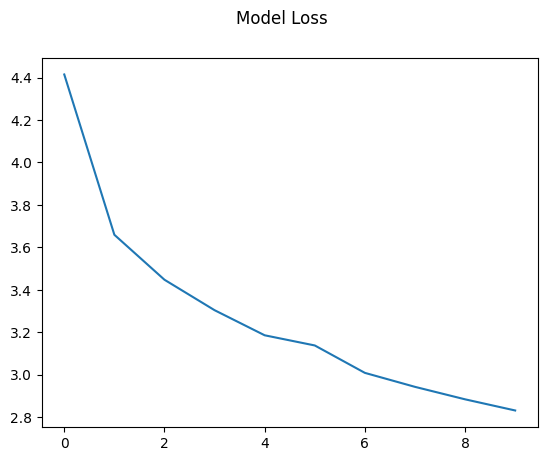

In [24]:
# Plot loss
plt.plot(model.history.history['loss'])
plt.suptitle("Model Loss")
plt.show()

In [ ]:
# Save model
model.save("image_caption_model.h5")

In [55]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


TEST_PATH = "Test/"
def write_caption(image_name, reference):
    caption = "<start>"
    
    image_path = os.path.join(TEST_PATH, image_name)
    image = Image.open(image_path).resize((224, 224))
    
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)   
    image = preprocess_input(image)

    feature = resnet.predict(image, verbose=0)

    while True:
        tokenized = tokenizer.texts_to_sequences([caption])[0]
        in_seq = pad_sequences([tokenized], maxlen=MAX_LENGTH, padding='post')[0].astype('int32')
        in_seq = np.expand_dims(in_seq, axis=0)
        pred = model.predict([feature, in_seq], verbose=0)
  
        next_word = np.argmax(pred[0])

        caption += " " + tokenizer.index_word[next_word]
        if tokenizer.index_word[next_word] == "end":
            break

        # print(caption)

    # Calculate BLEU score
    caption = caption[:-1].split(" ")[2: ]

    score = sentence_bleu(reference, caption, weights=(1,0,0,0))
    print(f"BLEU score: {score:.4f}")
    print(caption)

references = [
    ['two', 'dog', 'in', 'a', 'field'],
    ['two', 'dog', 'hugging', 'in', 'a', 'field'],
    ['two', 'dog', 'smiling', 'in', 'a', 'field']
]

write_caption("test.jpg", references)

BLEU score: 0.3333
['white', 'white', 'dog', 'running', 'field', 'en']


In [57]:
references = [
    ['man', 'with', 'a', 'white', 'shirt', 'and', 'a', 'hat'],
    ['man', 'holding', 'a', 'hat'],
    ['man', 'with', 'a', 'brown', 'bowler', 'hat']
]

write_caption("download.jpg", references)

BLEU score: 0.2222
['woman', 'wearing', 'white', 'shirt', 'white', 'shirt', 'white', 'shirt', 'en']


# TODO
- create another notebook to do it for Twitter data